# Subset discontinuity tracking
This deck contains proofing of subset splitting methodologies

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

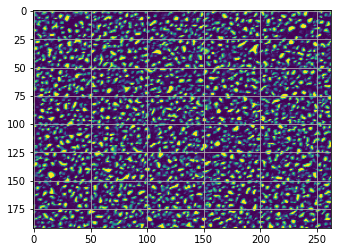

In [3]:
# preamble
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset
import os
import cv2

# folder path

folder_path=Path(r'D:\DIC\crosspy\data\tester_hor')
Images = Imset(folder_path,'tif')

# Image crop

crop_on = False

if crop_on:
    img = Images.imload([0,1])
    y = 175
    h = 1000
    x = 525
    w = 1000
    Images = img[y:y+h, x:x+w, :]
else:
    Images = Images.imload([0,1])
   
fig = plt.figure()
ax = fig.gca()
ax.imshow(Images[:,:,1])
#ax.set_xticks(np.arange(0, Images.shape[0], Images.shape[0]/10))
#ax.set_yticks(np.arange(0, Images.shape[1], Images.shape[1]/10))
plt.grid()


294
Running sequential DIC on image pair 1 of 1 ..., total subsets per image: 294
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 264 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:   11.2s finished
... Completed in (s) 11.53368353843689
Calculating strain on map 1 of 1 ...
... Completed in (s) 0.20644831657409668
Quick plotting strains


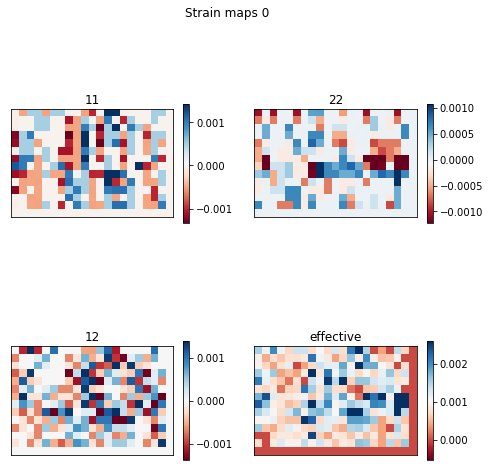


*** Profile printout saved to text file 'prun0'. 


In [4]:
%%prun -s cumulative -q -l 10 -T prun0
# Image crop

roi_1stpass = dict(size_pass = 50, overlap_percentage = 80, xcf_mesh=50)
filter_settings = [4,2,15,8]
# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)

print(dic_1stpass.n_subsets)
dic_1stpass.run_sequential(cores=4,hs=True)

# dic_1stpass.plot_displacements()
dic_1stpass.calculate_strain()
dic_1stpass.plot_strains()

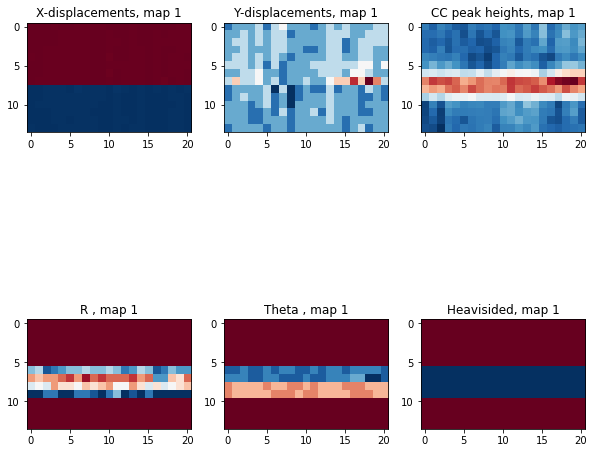

[]

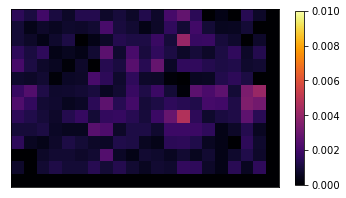

In [5]:
dic_1stpass.plot_displacements()




eff = dic_1stpass.strain_eff[:,:,0]
e11 = dic_1stpass.strain_11[:,:,0]
e22 = dic_1stpass.strain_22[:,:,0]
e12 = dic_1stpass.strain_12[:,:,0]
fig,ax = plt.subplots()


im1 = ax.imshow(eff, vmin=0,vmax=0.01, cmap="inferno")

fig.colorbar(im1, ax=ax, shrink=0.8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

In [6]:
print(open('prun0', 'r').read())

1200756 function calls (1165919 primitive calls) in 12.668 seconds

   Ordered by: cumulative time
   List reduced from 1964 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000   12.668   12.668 {built-in method builtins.exec}
        1    0.000    0.000   12.667   12.667 <string>:3(<module>)
        1    0.000    0.000   11.534   11.534 Classes.py:109(run_sequential)
        1    0.000    0.000   11.534   11.534 runDIC.py:13(run_DIC)
        1    0.000    0.000   11.297   11.297 parallel.py:946(__call__)
        1    0.018    0.018   11.273   11.273 parallel.py:906(retrieve)
      170    0.000    0.000   11.255    0.066 _parallel_backends.py:535(wrap_future_result)
      170    0.001    0.000   11.254    0.066 _base.py:405(result)
      152    0.001    0.000   11.254    0.074 threading.py:264(wait)
      360   11.252    0.031   11.252    0.031 {method 'acquire' of '_thread.lock' objects}


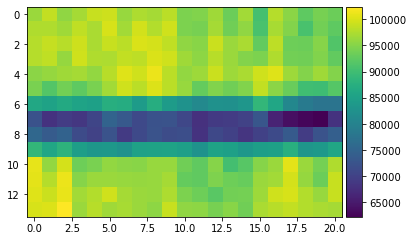

In [7]:
cc_peaks = dic_1stpass.ph_maps[:,:,0]
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot(111)
im = ax.imshow(cc_peaks)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

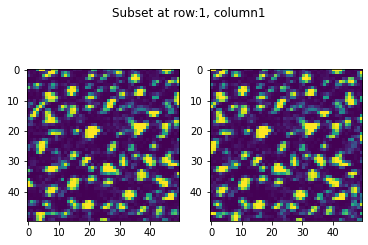

In [258]:
import cv2
filter_settings=[4,2,15,8]
ims = Images
#settings for heaviside pass
roi_disc = dict(size_pass = 50, overlap_percentage = 80, xcf_mesh=30)
dic_disc = DIC(ims, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=3, col=1, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets


    
# Select a subset, here at row 20, column 20

#subsets = get_subsets(ims,5, 0, roi_disc) # has slip
subsets = get_subsets(ims,1,1, roi_disc) # has no slip


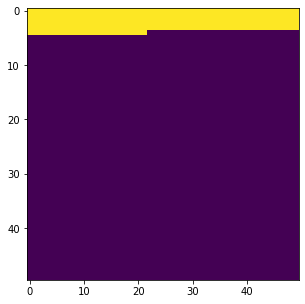

In [270]:

from numba import double, jit
from numba import int32, float32, uint8, jitclass
import numpy as np


# Apply a line and step function

spec = [
    ('x', float32),
    ('y', float32)
]

@jitclass(spec)
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 

@jit(nopython=True)
def line_test(pixel, r, theta, subsets):
    # function to test if a pixel lies above or below a line segment
    # Find start and end points of line segments for different cases of theta and r
    dx = subsets.shape[0]
    # Line segment to interogation point
    p1 = Point(0, 0)
    q1 = Point(pixel[0], pixel[1])
    
    # Vector magnitude cases
    #theta = np.degrees(theta)
    theta = theta % 360
    if r == 0:
        r = 1e-8
        
    # Rotation cases
    if theta == 0. or theta == 360.: # vertical to right
        x1 = r
        x2 = q1.x
        if x2 > x1:
            return False
        else:
            return True
    elif theta == 90.: # horizontal line above
        y1 = r
        y2 = q1.y
        if y2>y1:
            return False
        else:
            return True
    elif theta == 180.: # vertical to left
        x1 = -r
        x2 = q1.x
        if x2 > x1:
            return True
        else:
            return False
    elif theta == 270.: # horizontal below
        y1 = -r
        y2 = q1.y
        if y2 < y1:
            return False
        else:
            return True
    elif theta>0 and theta<180:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1>y2:
            return False
        else:
            return True
    elif theta>180 and theta<360:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1<y2:
            return False
        else:
            return True

@jit(uint8[:,:,:](uint8[:,:,:], float32, float32)) 
def gen_hsfilter(subsets, r, theta):
    # preallocate arrays
    hsfilter = np.zeros((subsets.shape[0],subsets.shape[0]), dtype="bool")
    xc = hsfilter.shape[0]/2
    yc = hsfilter.shape[1]/2
    xc = (xc)
    yc = (yc)

    # Create x and y coordinates which are centred
    xs,ys = np.meshgrid(np.linspace(-xc, xc,subsets.shape[0]), np.linspace(-yc,yc,subsets.shape[0]))

    # iterate pixel by pixel
    for col in range(subsets.shape[0]):
        for row in range(subsets.shape[0]):
            #rasters through columns and rows for a given coordinate in xy
            x = xs[row,col]
            y = ys[row,col]
            # Note that y axis is mirrored
            pixel = [x, (-1*y)]
            # Test if pixel is beyond the discontinuity line
            flag  =line_test(pixel, r, theta, subsets)
            if flag:
                hsfilter[row,col] = True
            else:
                hsfilter[row,col] = False
                
    return hsfilter



result = gen_hsfilter(subsets,r=21, theta=92)
result = ~result


f, ax = plt.subplots(figsize=(10,5))
ax.imshow(result[:,:])



Testing various correlation functions below

# FREG hs corr:

---> FXCORR is already the fastests and most accurate function available --> alternatively rewrite as a lightweight correlation function without subpixel registration

In [278]:
from crosspy import XCF

def hs_corr(x, subsets, d, prepared_ffts):
    # unpack vector
    r, theta = x
    # generate heaviside filter
    hsfilter = gen_hsfilter(subsets, r, theta)
    
    # assign to clean variables for legibility
    a = subsets[:,:,0]*hsfilter
    b = subsets[:,:,1]*hsfilter
    
    # cross correlate using freg - this is still faster than silly numpy correlate
    result = XCF.fxcorr(a, b, d, prepared_ffts)
    
    # normalise via division by active pixels
    act_px = np.count_nonzero(hsfilter != False)
    result = np.asarray(result)
    result[2] = result[2]/(np.sqrt(act_px))
    
    # return vectorised result containing dx,dy,cc
    return result

def hs_corr_inv(x,subsets,d,prepared_ffts):
    # unpack vector
    r,theta = x

    #apply heaviside
    hsfilter = gen_hsfilter(subsets, r, theta)

    # invert selection
    hsfilter_inv = ~hsfilter

    # apply to clean variables
    a = subsets[:,:,0] * hsfilter_inv
    b = subsets[:,:,1] * hsfilter_inv
    # cross correlate using freg
    result = XCF.fxcorr(a, b, d, prepared_ffts)

    # normalise by active pixels
    act_px = np.count_nonzero(hsfilter_inv != False)
    result = np.asarray(result)
    result[2] = result[2]/np.sqrt(act_px)

    return result

prepared_ffts = XCF.plan_ffts(dic_disc)

r = 0
theta = 0

tester = hs_corr([r,theta], subsets, dic_disc, prepared_ffts)
tester_inv = hs_corr_inv([r,theta], subsets, dic_disc, prepared_ffts)

print("hs_corr", tester)
print("hs_corr_inv", tester_inv)



hs_corr [-3.96666667e+00 -3.33333333e-02  3.88659477e+08]
hs_corr_inv [-3.96666667e+00 -3.33333333e-02  3.85230611e+08]


# Plotting in 3d

[4.73684211] [94.73684211]


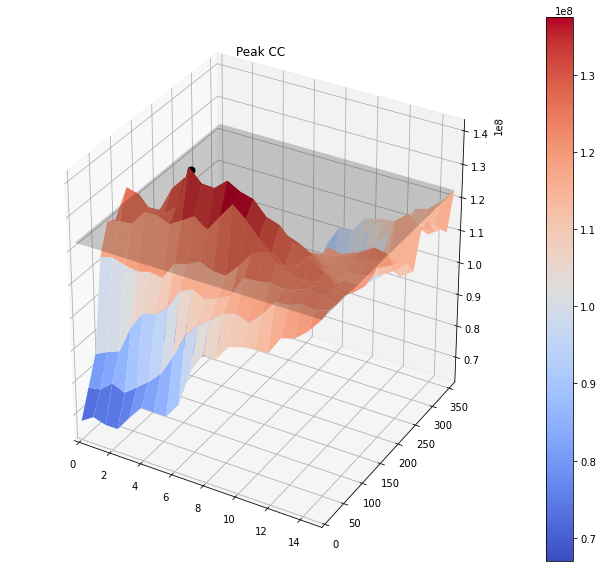

In [11]:
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    dxi,dyi,ci=hs_corr_inv(x,subsets,d,prepared_ffts)
    return c,ci

n = 20
rs = np.linspace(0,np.sqrt((subsets.shape[0]/2)**2), n)
ths = np.linspace(0,360,n)
x, y = np.meshgrid(rs,ths)

a = subsets[:,:,0]
b = subsets[:,:,1]

result = XCF.fxcorr(a, b, dic_disc, prepared_ffts)
floor = np.full((x.shape),result[2]/np.sqrt(subsets.shape[0]**2))

vals = np.c_[np.ravel(x),np.ravel(y)]

fx = np.array([hsin(val, subsets, dic_disc, prepared_ffts) for val in vals]).reshape(n,n,2)

import numpy.ma as ma 

fx = np.where(np.isnan(fx),0,fx)
titles = ["Peak CC"]
fig = plt.figure(figsize=(25,10))
for i in range(1):
    ax = fig.add_subplot(1,2,i+1, projection='3d')
    z = fx[:,:,i]#/(x)
    #z = np.divide(z, x, out=np.zeros_like(z), where=x!=0)
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha =1.0)#, linewidth=0, antialiased=False)
    surf2 = ax.plot_surface(x, y, floor, color='k', alpha =0.2)#, linewidth=0, antialiased=False)
    ax.set_xlim(rs.min(), rs.max())
    ax.set_ylim(ths.min(), ths.max())
    ax.set_zlim(z.min(), z.max())
    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    #fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_title(titles[i])
    # add a point indicating peak location
    loc = np.where(z.max() == z)
    xmx =x[loc]
    ymx =y[loc]
    zmx =z[loc]
    
    ax.scatter(xs=5,ys=90,zs=zmx,s=50,c='k')
    fig.colorbar(surf, ax=ax)
    print(xmx,ymx)


plt.show()

# Bayesian optimization for noisy, expensive, black box functions - no gradient descent needed - > GOOD FOR FIRST ORDER APPROXIMATION

In [277]:
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize
def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return -dx
@jit
def opt_rt(subsets, n_calls, d, prepared_ffts):
    # Initial naked search
    a = subsets[:,:,0]
    b = subsets[:,:,1]
    dx1, dy1, cc1 = XCF.fxcorr(a, b, d, prepared_ffts)
    # local function
    
    # define search boundary
    bounds = [(0., subsets.shape[0]/2), (0., 360.0)]
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    # Use a Bayesian-gauss optimisation to approximate minimum
    res = gp_minimize(func,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=n_calls,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=1e-8,       # the noise level (optional)
                  random_state=1234)   # the random seed
    x = res.x
    r = np.around(x[0],2)
    theta = np.around(x[1],2)
    print(r,theta)
    dx0, dy0, cc0 = hs_corr(x, subsets, d, prepared_ffts)
    # Accept the approximation only if the peak height is 
    # significantly higher than the naked cross correlation
    cc1 = cc1/(subsets.shape[0]**2)
    if np.abs(cc0/cc1) >= 1.0 and r != 0.0:     
        return dx0, dy0, cc0, r, theta, True
    else:
        return dx1, dy1, cc1, False, False, False


    
def minimize_rt(subsets,d,prepared_ffts):
    dx, dy, cc, r, theta, hson = opt_rt(subsets,20, d, prepared_ffts)
    #print("r = {}, theta = {}".format(r,theta))
    return dx,dy,cc,r,theta,hson

dx, dy, cc, r, theta, hson = minimize_rt(subsets,dic_disc, prepared_ffts)

print(r,theta)


0.0 56.06
False False


In [13]:
from scipy import optimize

def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return dx,dy,c

def minimise_scipy(subsets,d,prepared_ffts):


    x0 = [5,45]
    bounds = ([0,0],[subsets.shape[0],360])
    res = optimize.least_squares(fun=hsin,x0=x0,bounds=bounds, args=(subsets,d,prepared_ffts))

    return res

print(minimise_scipy(subsets,dic_disc,prepared_ffts).x)

[ 5. 45.]


In [14]:
# Least squares

def hsin(x,subsets,d,prepared_ffts):
    _,_,c=hs_corr(x,subsets,d,prepared_ffts)
    return c

@jit
def A_mat(x,y=0,n=2):
    # Function to generate A matrices for polynomial solutions of Ax = b
    if n == 2:
        A = np.zeros((len(x),6))
        A[:,0]=np.squeeze(x**2)
        A[:,1]=np.squeeze(x)
        A[:,2]=np.squeeze(y**2)
        A[:,3]=np.squeeze(y)
        A[:,4]=np.squeeze(x*y)
        A[:,5]=np.ones(len(x))
        return A
    elif n == 3:
        A = np.zeros((len(x),10))
        A[:,0]=np.squeeze(x**3)
        A[:,1]=np.squeeze((x**2)*y)
        A[:,2]=np.squeeze(x*(y**2))
        A[:,3]=np.squeeze(y**3)
        A[:,4]=np.squeeze(x**2)
        A[:,5]=np.squeeze(x*y)
        A[:,6]=np.squeeze(y**2)
        A[:,7]=np.squeeze(x)
        A[:,8]=np.squeeze(y)
        A[:,9]=np.ones(len(x))
        return A
    elif n == 4:
        A = np.zeros((len(x),15))
        A[:,0]=np.squeeze(x**4)
        A[:,1]=np.squeeze(y**4)
        A[:,2]=np.squeeze((x**3)*y)
        A[:,3]=np.squeeze((x**2) * (y**2))
        A[:,4]=np.squeeze(x*(y**3))
        A[:,5]=np.squeeze(x**3)
        A[:,6]=np.squeeze(y**3)
        A[:,7]=np.squeeze((x**2)*y)
        A[:,8]=np.squeeze(x*(y**2))
        A[:,9]=np.squeeze(x**2)
        A[:,10]=np.squeeze(y**2)
        A[:,11]=np.squeeze(x*y)
        A[:,12]=np.squeeze(x)
        A[:,13]=np.squeeze(y)
        A[:,14]=np.ones(len(x))
        return A




In [275]:
def least_squares_xcf(n, resolution, subsets, d, prepared_ffts):
    min_angle = 0
    max_angle = 180
    # generate mesh spaces
    r_max = subsets.shape[0]/2
    r = np.linspace(1, r_max,resolution)
    theta = np.linspace(min_angle, max_angle, resolution)

    x_measured, y_measured = np.meshgrid(r, theta)

    # unravel to 1d
    r = x_measured.ravel()
    theta = y_measured.ravel()

    # generate trial Ax=b based on measured response
    atr = A_mat(r, theta, n)
    vals = np.c_[r,theta]

    # here we measure XCF
    btr = np.array([hsin(val, subsets, d, prepared_ffts) for val in vals])
    fx_measured = btr.reshape(resolution, resolution)
    # x params
    x, _, _, _ = np.linalg.lstsq(atr,btr)


    # populate modelling space
    n_mod = 1000
    r = np.linspace(1, r_max, n_mod)
    theta = np.linspace(min_angle, max_angle, n_mod)
    x_mod,y_mod = np.meshgrid(r, theta)

    # unravel to 1d
    r = x_mod#.ravel()
    theta = y_mod#.ravel()

    # obtain modelling solution

    if n == 2:
        fx = x[0]*r**2 + x[1]*r + x[2]*theta**2 + x[3]*theta + x[4]*theta*r + x[5]
    elif n == 3:
        fx = (x[0]*r**3 + x[1]*(r**2)*theta + x[2]*r*(theta**2) 
            + x[3]*theta**3 + x[4]*r**2 + x[5]*r*theta + x[6]*theta**2 
            + x[7]*r + x[8]*theta + x[9])
    elif n == 4:
        fx = (x[0]*r**4 + x[1]*theta**4 + x[2]*(r**3)*theta
            + x[3]*(r**2)*(theta**2) + x[4]*r*(theta**3) + x[5]*r**3
            + x[6]*theta**3 + x[7]*(r**2)*theta + x[8]*r*(theta**2)
            + x[9]*r**2 + x[10]*theta**2 + x[11]*r*theta + x[12]*r
            + x[13]*theta + x[14])

    # find maximum
    loc = np.where(fx.max() == fx)
    rsol = r[loc]
    thetasol = theta[loc]

    return rsol, thetasol

rsol, thetasol = least_squares_xcf(4, 10, subsets, dic_disc, prepared_ffts)

print(rsol,thetasol)

[21.01201201] [0.]


In [272]:
# simple function to search angle space
from scipy import optimize
import matplotlib.ticker as mtick
def peak_angle(resolution, subsets, d, prepared_ffts):

    def hsin(x,subsets,d,prepared_ffts):
        _,_,c=hs_corr(x,subsets,d,prepared_ffts)
        return c


    theta = np.linspace(0, 360, resolution)
    theta_mod = np.linspace(0,360,10000)
    r = np.full(len(theta), subsets.shape[1]/100)

    # def A_mat(x):
    #     A = np.zeros((len(x),5))
    #     A[:,0]=np.squeeze(x**4)
    #     A[:,1]=np.squeeze(x**3)
    #     A[:,2]=np.squeeze(x**2)
    #     A[:,3]=np.squeeze(x)
    #     A[:,4]=np.ones(len(x))
    #     return A

   
    # generate trial Ax=b based on measured response
    atr = A_mat(theta)
    vals = np.c_[r,theta]
    

    # here we measure XCF
    
    fx = np.array([hsin(val,subsets, d, prepared_ffts) for val in vals])
    
    # fit a sin function
    
    fx = fx-np.mean(fx)

    # trial_func = lambda c,x: c[0] + c[1]*np.cos(x)

    # def A_mat_sin(x):
    #     A = np.zeros((len(x),2))
    #     A[:,0] = np.ones(len(x))
    #     A[:,1] = np.squeeze(np.cos(x))
    #     return A
    
    # th = np.radians(theta)*2
    # A = A_mat_sin(th)

    # x, _, _, _ = np.linalg.lstsq(A, fx)
    
    # th = np.radians(theta_mod)*2
    # fx_m = trial_func(x,th)

    # fit sin 2

    trial_func = lambda c,x : c[0] + c[1]*np.sin(x) + c[2]*np.cos(x)

    def A_mat_sin(x):
        A = np.zeros((len(x),3))
        A[:,0] = np.ones(len(x)) # a0
        A[:,1] = np.squeeze(np.sin(x)) #a1
        A[:,2] = np.squeeze(np.cos(x)) #b0
        return A

    th = np.radians(theta)*2
    A = A_mat_sin(th)

    x, _, _, _ = np.linalg.lstsq(A, fx)
    
    th = np.radians(theta_mod)*2
    fx_m = trial_func(x,th)
    # plot for the sake of it

    # fig, ax = plt.subplots()
    # ax.scatter(theta,fx)
    # ax.plot(np.degrees(th)/2, fx_m)
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    # plt.show()


    loc = np.where(fx_m.max() == fx_m)
    
    th_mx = th[loc]

    if not th_mx:
        return False

    theta_est = int(np.degrees(th_mx[0]/2))
    theta_est2 = int((theta_est+180) % 360)

    c1 = hsin(np.array([r[0],theta_est]),subsets, d, prepared_ffts)
    c2 = hsin(np.array([r[0],theta_est2]),subsets, d, prepared_ffts)

    if c1>c2:
        return  np.uintc(theta_est)
    else:
        return  np.uintc(theta_est2)


thetasol = peak_angle(20, subsets, dic_disc, prepared_ffts)
print(thetasol)

92


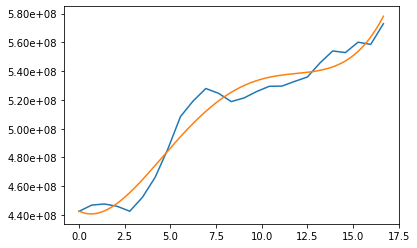

16


In [274]:


def peak_r(theta, resolution, subsets, d, prepared_ffts):
    if not theta:
        return False, False, False

    def hsin(x,subsets,d,prepared_ffts):
        _,_,c=hs_corr(x,subsets,d,prepared_ffts)
        return c
    # angle space
    theta = np.full((resolution),theta)

    # create search space in r
    r_max = subsets.shape[1]/3
    r = np.linspace(0,r_max,resolution)

    c = np.column_stack((r,theta))

    # search
    fx = np.array([hsin(val,subsets, d, prepared_ffts) for val in c])

    # create model

    def A_mat(x):
        A = np.zeros((len(x),6))
        A[:,0]=np.squeeze(x**4)
        A[:,1]=np.squeeze(x**3)
        A[:,2]=np.squeeze(x**2)
        A[:,3]=np.squeeze(x)
        A[:,4]=np.ones(len(x))
        return A

    # Ax = b

    A = A_mat(c[:,0])
    x, _, _, _ = np.linalg.lstsq(A,fx)
  
    # model

    r_m = np.linspace(0,r_max,1000)
    fx_m = x[0]*r_m**4 + x[1]*r_m**3 + x[2]*r_m**2 + x[3]*r_m + x[4]

    # plot for fun

    fig, ax = plt.subplots()

    ax.plot(r,fx, r_m, fx_m)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.show()

    # find peak
    # model
    loc = np.where(fx_m.max() == fx_m)
    r_sol = r_m[loc]

    # measure

    loc = np.where(fx.max() == fx)
    r_sol = r[loc]

    return int(r_sol[0]), np.mean(fx_m), np.max(fx_m) 

rsol, _, _ = peak_r(thetasol, 25, subsets, dic_disc, prepared_ffts)

print(rsol)

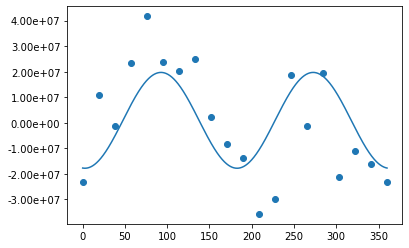

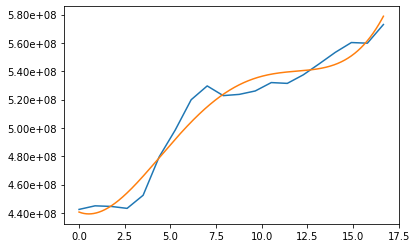

array([-3.96666667e+00, -3.33333333e-02,  1.21684894e+07,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [262]:
def least_squares_fit(res, subsets, d,prepared_ffts):
    theta = peak_angle(res, subsets, d, prepared_ffts)
    r, xcf_mean, xcf_peak = peak_r(theta, res, subsets, d, prepared_ffts)
    return r, theta, xcf_mean, xcf_peak

def minimise_rt_lstsq(subsets, d, prepared_ffts):

    # obtain peak r and theta
    r, theta, xcf_mean, xcf_peak = least_squares_fit(20, subsets, dic_disc, prepared_ffts)
    x = np.array([r,theta])
    # obtain dx,dy,cc from r,theta
    dx,dy,cc=hs_corr(x,subsets,d,prepared_ffts)

    # obtain inverted peak cc from other side of r,theta
    dxi,dyi,cci = hs_corr_inv(x,subsets,d,prepared_ffts)
    # obtain untreated dx,dy,
    dxu, dyu, ccu = XCF.fxcorr(subsets[:,:,0], subsets[:,:,1], d, prepared_ffts)

    # compare values
    comp = lambda a,b : np.minimum(a,b)/np.maximum(a,b)
    xval = comp(dx,dxi)
    yval = comp(dy,dyi)
    ccval = comp(cc,cci)
    ccu = ccu/(subsets.shape[0]**2)

    # # check if dx and dy are similar
    # if abs(xval)<0.9 or abs(yval)<0.9: #xcf_peak > ccu:
    #     return np.array([dx,dy,cc,r,theta,True])
    # else:
    #     return np.array([dxu,dyu,ccu,False,False,False])

    if xval > 0 and yval > 0: # both dx and dy are in the same direction
        # Both in same direction => no discontinuity
        return np.array([dxu,dyu,ccu,False,False,False])
    elif xval < 0 or yval < 0 and cc>ccu: # both dx or dy are in opposite directions
        # One value does not match direction
        return np.array([dx,dy,cc,r,theta,True])
    else:
        print('FALSE ARRAYS')
        return np.array([dxu,dyu,ccu,False,False,False])


(minimise_rt_lstsq(subsets, dic_disc, prepared_ffts))

In [237]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


surf = ax.plot_surface(x_mod, y_mod, fx, cmap=cm.coolwarm, alpha=0.9,linewidth=1.0)#, linewidth=0, antialiased=False)
surf_measured = ax.plot_surface(x_measured, y_measured, fx_measured,cmap=cm.inferno, linewidth=0.5,alpha=0.1)
ax.set_xlim(x_mod.min(), x_mod.max())
ax.set_ylim(y_mod.min(), y_mod.max())
ax.set_zlim(fx.min(), fx.max())
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(surf_measured, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

NameError: name 'x_mod' is not defined

In [16]:
def subset_compare(subset_n,d,imnos,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        dxs, dys, phs,r,theta, hson = minimise_rt_lstsq(subsets,d, prepared_ffts)
        return dxs, dys, phs, r, theta, hson
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None


#Finepass

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import functools
import pyfftw
from crosspy.XCF import *
from crosspy.ImagePreparation import *
#from crosspy.runDIC import subset_compare
import numexpr as ne
from joblib import Parallel, delayed
from multiprocessing import Pool
from functools import partial

# preallocate

roi_disc = dict(size_pass = 40, overlap_percentage = 80, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)

def run_DIC(d,imnos=[0,1],hs=False, cores=None,ffttype='fftw_numpy'):
    #fft type can be : fftw_numpy (default), fftw_scipy, else defaults to numpy

    #set up numexpr to run with the chosen number of threads
    
    #discontinuity enables or disables slip trace tracking via heaviside filtering


    #preallocate for this DIC pair
    phs=np.zeros(d.n_subsets)
    dxs=np.zeros(d.n_subsets)
    dys=np.zeros(d.n_subsets)

    prepared_ffts=plan_ffts(d,ffttype)


    #enable the pyfftw cache for speedup
    pyfftw.interfaces.cache.enable()   
    
    # start mp pool

    #check for discontinuity tracker
    if hs == True:
        r = np.zeros(d.n_subsets)
        theta = np.zeros(d.n_subsets)
        hson = np.zeros(d.n_subsets)
        results = np.zeros((d.n_subsets,6))

        results = Parallel(n_jobs=cores, verbose=5)(delayed(subset_compare)(d=dic_disc, imnos=[0,1], subset_n=i, prepared_ffts=prepared_ffts,                     hs=True) for i in range(0,dic_disc.n_subsets))

        dxs,dys,phs,r,theta,hson = zip(*results)

        # convert to maps
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')
        r_map = np.reshape(r,(d.n_rows,d.n_cols),'F')
        theta_map = np.reshape(theta,(d.n_rows,d.n_cols),'F')
        hson_map = np.reshape(hson,(d.n_rows,d.n_cols),'F')
        return dx_map, dy_map, ph_map, r_map, theta_map, hson_map
    else:
        results = np.zeros((d.n_subsets,3))

        results = Parallel(n_jobs=cores, verbose=5)(delayed(subset_compare)(d=dic_disc, imnos=[0,1], subset_n=i, prepared_ffts=prepared_ffts) for i in            range(0,dic_disc.n_subsets))

        dxs,dys,phs = zip(*results)

        # convert to maps
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')

        return dx_map,dy_map,ph_map

if __name__=='__main__':

    dx_map, dy_map, ph_map, r_map, theta_map, hson_map = run_DIC(dic_disc, hs=True, cores=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x2cdbfa154e0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\Alex\anaconda3\envs\crosspy\lib\site-packages\joblib\externals\loky\process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Users\Alex\anaconda3\envs\crosspy\lib\multiprocessing\queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "C:\Users\Alex\anaconda3\envs\crosspy\lib\site-packages\joblib\externals\cloudpickle\cloudpickle.py", line 1257, in _make_skeleton_class
    lambda ns: ns.update(type_kwargs)
  File "C:\Users\Alex\anaconda3\envs\crosspy\lib\types.py", line 70, in new_class
    return meta(name, resolved_bases, ns, **kwds)
  File "C:\Users\Alex\anaconda3\envs\crosspy\lib\site-packages\numba\experimental\jitclas

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

(19, 27)


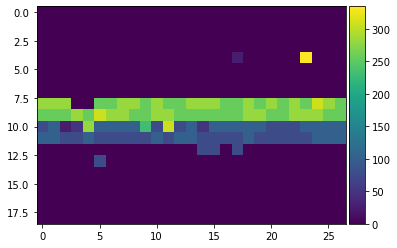

In [281]:
print(dx_map.shape)
ax = plt.subplot(111)
im = ax.imshow(theta_map)

from mpl_toolkits.axes_grid1 import make_axes_locatable
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


In [42]:
import sys
import time
import traceback
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from crosspy.runDIC import subset_compare

r = np.zeros(d.n_subsets)
theta = np.zeros(d.n_subsets)
hson = np.zeros(d.n_subsets)

results = Parallel(n_jobs=6, verbose=5)(delayed(subset_compare)(d=dic_disc, imnos=[0,1], subset_n=i, prepared_ffts=prepared_ffts, discontinuity=True) for i in range(0,dic_disc.n_subsets))


dxs,dys,phs,r,theta,hson = zip(*results)

d= dic_disc
dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')
r_map = np.reshape(r,(d.n_rows,d.n_cols),'F')
theta_map = np.reshape(theta,(d.n_rows,d.n_cols),'F')
hson_map = np.reshape(hson,(d.n_rows,d.n_cols),'F')

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    8.6s finished


In [239]:
from numba import njit, prange
from crosspy.XCF import *
from crosspy.ImagePreparation import *
roi_disc = dict(size_pass = 50, overlap_percentage = 80, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)

import time
@jit
def subset_compare(subset_n,d,imnos,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        results = minimise_rt_lstsq(subsets,d, prepared_ffts)
        return results
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None

prepared_ffts = plan_ffts(dic_disc,ffttype='fftw_numpy')
@jit(parallel=False)
def run_DIC_cuda(d,prepared_ffts,imnos=[0,1],discontinuity=False, cores=None, ffttype='fftw_numpy'):
    #fft type can be : fftw_numpy (default), fftw_scipy, else defaults to numpy

    #set up numexpr to run with the chosen number of threads
    
    #discontinuity enables or disables slip trace tracking via heaviside filtering


    #pre-allocate for this DIC pair
    phs=np.zeros(d.n_subsets)
    dxs=np.zeros(d.n_subsets)
    dys=np.zeros(d.n_subsets)

    #enable the pyfftw cache for speedup
    pyfftw.interfaces.cache.enable()   

    #check for discontinuity tracker
    if discontinuity == True:
        #pre-allocate heavisde assets
        r = np.zeros(d.n_subsets)
        theta = np.zeros(d.n_subsets)
        hson = np.zeros(d.n_subsets)
        results = np.zeros((len(r),6))

        #main DIC loop - iterates through subsets
        i = 0
        for subset_n in prange(0,d.n_subsets):
            results[i,:] = subset_compare(subset_n,d,imnos,prepared_ffts, True)
            i +=1
        dxs = results[:,0]
        dys = results[:,1]
        phs = results[:,2]
        r = results[:,3]
        theta = results[:,4]
        hson = results[:,5]
        #format to maps
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')
        r_map = np.reshape(r,(d.n_rows,d.n_cols),'F')
        theta_map = np.reshape(theta,(d.n_rows,d.n_cols),'F')
        hson_map = np.reshape(hson,(d.n_rows,d.n_cols),'F')

        return dx_map, dy_map, ph_map, r_map, theta_map, hson_map
    else:
        for subset_n in range(0,d.n_subsets):
            dxs[subset_n],dys[subset_n],phs[subset_n]=subset_compare(d,imnos,subset_n,prepared_ffts)

        #translate best_dxs etc back onto image grid
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')

        return dx_map,dy_map,ph_map

if __name__=='__main__':
    start = time.time()
    #dx_map, dy_map, ph_map, r_map, theta_map, hson_map = run_DIC_cuda(dic_disc, discontinuity=True, prepared_ffts=prepared_ffts)
    dx_map, dy_map, ph_map, r_map, theta_map, hson_map = run_DIC_cuda(dic_disc, discontinuity=True, prepared_ffts=prepared_ffts)
    #run_DIC_cuda.parallel_diagnostics(level=4)
    end = time.time()
    print(end - start)

39.14882040023804


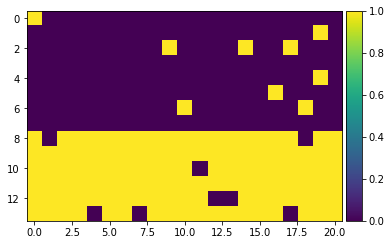

In [242]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.subplot(111)
im = ax.imshow(hson_map)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

In [35]:

def subset_compare(subset_n,d,imnos,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        #r,theta=opt_rt(subsets, n_calls=10, d=d, prepared_ffts=prepared_ffts)
        #dxs,dys,phs = hs_corr([r,theta],subsets,d=d,prepared_ffts=prepared_ffts)
        #dxs, dys, phs,r,theta, hson = minimize_rt(subsets,d,prepared_ffts)
        dxs, dys, phs,r,theta, hson = minimise_rt_lstsq(subsets,d, prepared_ffts)
        return dxs, dys, phs, float(r), float(theta), float(hson)
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None

subset_compare(1,dic_disc,[0,1],prepared_ffts, True)

subset_compare.parallel_diagnostics(level=4)

AttributeError: 'function' object has no attribute 'parallel_diagnostics'